# Capstone Project

### Problem Statement

A new family is currently living in the Bushwick Neighborhood of Brooklyn, New York. However, upon the expansion of their family through the birth of two children, they are seeking to return to Upstate, New York where they originally hail. The couple would like to live in a neighbhorhood that is similar in diversity and amenities to their current neighborhood (ridgewood), and is currently investigating Troy, Schenectady, and Albany, New York as potentially suitable communities. 

The goal of this analysis is to investigate Troy, Schenectady, and Albany, New York (which are small enough that they will be analyzed as whole cities), and determine if one of the cities in Upstate, NY will provide a close approximation of the living conditions of Ridgewood, Brooklyn, NY USA. 

### Data

The analysis will take place by examining the following pieces of available data: 
    
    - Foursquare API Data for all identified cities and neighborhoods. 
    - Mean Housing price/cost information from Zillow
    - Federal regional cost of living adjustment data (to normalize home values between NYC and Albany, Schenectady, and Troy.

### Analysis Methodology

The Analysis of all data will take place in the following manner: 
    - First Albany, Schenectady, and Troy venues and their venue categories will be analyzed with NYC venue data and clustered to determine if any of those three cities are similar to Bushwick. 
    - The second part of the analysis will be a review of single family housing costs normalized against neighborhood housing costs for Bushwick, Brooklyn, USA
    - The final piece of the analysis will be a brief demography study using a quick literature search to build a comparison table of each city. 

In [1]:
import numpy as np # library to handle data in a vectorized manner

!pip install BeautifulSoup4
from bs4 import BeautifulSoup

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib.request

!pip install html5lib
!pip install lxml
!pip install et_xmlfile

from pandas import DataFrame

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

In [2]:
# Obtain NYC Borough Data.
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

#load json. 
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#define json features. 
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe with the column names you just defined above. 
neighborhoods = pd.DataFrame(columns=column_names)

#fill in neighborhood data for NYC. 
for data in neighborhoods_data: #for data in neighborhoods data - which is the json format crap form above. for 'data' not sure what that's reading from. but it appears to be essentilaly length in the frame.
    borough = neighborhood_name = data['properties']['borough'] #this is because there's two dicts in the properties field
    neighborhood_name = data['properties']['name'] #this is becuase there's two dicts in the "properties" field
        
    neighborhood_latlon = data['geometry']['coordinates'] #
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Check the dataframe has all 5 boroughs. 
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

Data downloaded!
The dataframe has 5 boroughs and 306 neighborhoods.


In [ ]:
### Create Map of NYC Data to Check that it's working. 

In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map for lat, lng, borough, neighborhood in zip() which combines all of the fields together as a single dict. 
#for each of these items. labe - had a lable, which will be neibhrohood and borough
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)#add neighborhood and borough label
    label = folium.Popup(label, parse_html=True) #add popup label as the label with borough and neighborhood
    folium.CircleMarker( #define circle markers
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [ ]:
url = ('https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}').format(client_id, 
                                                                  client_secret, 
                                                                  version,
                                                                  neighborhood_latitude, 
                                                                  neighborhood_longitude, 
                                                                  radius,
                                                                  limit)

In [30]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True) #define a new dataframe of just brooklyns neighborhoods.
brooklyn_data.head(3)

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316


In [12]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [19]:
# The code was removed by Watson Studio for sharing.

In [21]:
#Code to get brooklyn neighborhood venues. 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            bk_radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) #cleans the data. 
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
bk_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude'])

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [23]:
# function that extracts the category of the venue 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
bk_venues.head(1)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa


In [25]:
#Clean the BK Data. 
# one hot encoding
bk_onehot = pd.get_dummies(bk_venues[['Venue Category']], prefix="", prefix_sep="") ##this is important. 

# add neighborhood column back to dataframe
bk_onehot['Neighborhood'] = bk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bk_onehot.columns[-1]] + list(bk_onehot.columns[:-1])
bk_onehot = bk_onehot[fixed_columns]

bk_onehot.head(2)

,Yoga Studio,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Video 

In [173]:
bk_grouped = bk_onehot.groupby('Neighborhood').mean().reset_index() #each of these means is the total number of all venues on the denominaotr and the # of that venue type as the numerator.  e.g. (1/66)
bk_grouped

NameError: name 'bk_onehot' is not defined

In [38]:
#Get New York Data

ny_addys = ['Schenectady, NY', 'Troy, NY', 'Albany, NY']
ny_lats = []
ny_long = []

for i in range(0,3) : 
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(ny_addys[i])
    latitude = location.latitude
    longitude = location.longitude
    ny_lats.append(latitude)
    ny_long.append(longitude)
    
    #print('The geograpical coordinate of {} are {}, {}.'.format(ny_addys[i],latitude, longitude))

#create a neighborhood dataframe out of the information used to search for lat longs. Going to use this to search the Foursquare API. 
upstate = pd.DataFrame({'Neighborhood': ny_addys, 'Latitude': ny_lats, 'Longitude': ny_long})
upstate.head(3)


,Neighborhood,Latitude,Longitude
0,"Schenectady, NY",42.814243,-73.939569
1,"Troy, NY",42.728412,-73.691788
2,"Albany, NY",42.651167,-73.754968


In [ ]:
#redefine nearbyvenues function. with new function. 

In [50]:
#Get upstate, NY Venues: 
#redefine the radius

bk_radius = ny_radius
#print(bk_radius)

upstate_venues = getNearbyVenues(names=upstate['Neighborhood'],
                                   latitudes=upstate['Latitude'],
                                   longitudes=upstate['Longitude'])

Schenectady, NY
Troy, NY
Albany, NY


In [124]:
#clean up the neighborhood names by getting rid of the commas. Join it back on in the  neighborhood Name.
city_only = upstate_venues.Neighborhood.str.split(",",expand=True)
upstate_venues['Neighborhood'] = city_only[0]
upstate_venues.head(3)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Schenectady,42.814243,-73.939569,"Ambition Coffee & Eatery, Inc",42.813251,-73.940701,Sandwich Place
1,Schenectady,42.814243,-73.939569,Tara Kitchen,42.814826,-73.940049,Moroccan Restaurant
2,Schenectady,42.814243,-73.939569,Proctor's Theatre,42.811866,-73.942157,Performing Arts Venue


In [125]:
#time to clean up the upstate, NY data. 
# one hot encoding
upstate_onehot = pd.get_dummies(upstate_venues[['Venue Category']], prefix="", prefix_sep="") ##this is important. 

# add neighborhood column back to dataframe
upstate_onehot['Neighborhood'] = upstate_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [upstate_onehot.columns[-1]] + list(upstate_onehot.columns[:-1])
upstate_onehot = upstate_onehot[fixed_columns]

upstate_onehot.head(2)

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Bookstore,Bowling Alley,Brewery,Burger Joint,Burrito Place,Café,Coffee Shop,College Hockey Rink,College Library,College Theater,Concert Hall,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,New American Restaurant,Noodle House,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pub,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Steakhouse,Student Center,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Schenectady,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Schenectady,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
#group the upstate, NY data. 
upstate_grouped = upstate_onehot.groupby('Neighborhood').mean().reset_index() #each of these means is the total number of all venues on the denominaotr and the # of that venue type as the numerator.  e.g. (1/66)
upstate_grouped

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Asian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beer Bar,Beer Garden,Beer Store,Bookstore,Bowling Alley,Brewery,Burger Joint,Burrito Place,Café,Coffee Shop,College Hockey Rink,College Library,College Theater,Concert Hall,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,English Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Historic Site,History Museum,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Nature Preserve,New American Restaurant,Noodle House,Park,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Pizza Place,Plaza,Pub,Rental Car Location,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Steakhouse,Student Center,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Albany,0.046512,0.011628,0.00,0.00,0.00,0.00,0.00,0.00,0.023256,0.011628,0.011628,0.011628,0.00,0.011628,0.00,0.023256,0.011628,0.00,0.093023,0.023256,0.00,0.00,0.00,0.00,0.034884,0.034884,0.011628,0.023256,0.034884,0.011628,0.00,0.011628,0.011628,0.00,0.011628,0.00,0.011628,0.00,0.00,0.00,0.011628,0.00,0.00,0.00,0.00,0.011628,0.011628,0.00,0.00,0.011628,0.00,0.011628,0.023256,0.011628,0.00,0.00,0.00,0.011628,0.00,0.00,0.011628,0.011628,0.011628,0.00,0.00,0.00,0.011628,0.011628,0.011628,0.011628,0.034884,0.023256,0.046512,0.011628,0.011628,0.011628,0.00,0.011628,0.046512,0.011628,0.00,0.00,0.034884,0.00,0.00,0.00,0.011628,0.00,0.00,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628,0.011628
1,Schenectady,0.020000,0.000000,0.00,0.01,0.00,0.00,0.00,0.02,0.080000,0.000000,0.000000,0.010000,0.00,0.010000,0.01,0.020000,0.000000,0.01,0.020000,0.010000,0.01,0.00,0.00,0.00,0.070000,0.010000,0.020000,0.040000,0.030000,0.000000,0.01,0.000000,0.050000,0.00,0.000000,0.01,0.010000,0.01,0.00,0.01,0.000000,0.01,0.01,0.00,0.00,0.010000,0.000000,0.01,0.01,0.010000,0.01,0.010000,0.050000,0.000000,0.00,0.01,0.00,0.070000,0.01,0.00,0.000000,0.000000,0.010000,0.00,0.01,0.01,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.050000,0.04,0.000000,0.040000,0.000000,0.01,0.00,0.020000,0.00,0.01,0.00,0.010000,0.00,0.00,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Troy,0.010000,0.000000,0.01,0.00,0.01,0.02,0.01,0.04,0.090000,0.000000,0.000000,0.010000,0.01,0.010000,0.01,0.020000,0.020000,0.00,0.010000,0.030000,0.00,0.01,0.01,0.01,0.050000,0.000000,0.000000,0.030000,0.020000,0.000000,0.00,0.000000,0.020000,0.01,0.000000,0.01,0.010000,0.00,0.01,0.00,0.000000,0.00,0.02,0.01,0.01,0.000000,0.010000,0.00,0.00,0.000000,0.00,0.030000,0.020000,0.010000,0.01,0.00,0.01,0.020000,0.01,0.01,0.010000,0.010000,0.020000,0.01,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.040000,0.010000,0.000000,0.010000,0.07,0.000000,0.020000,0.000000,0.01,0.01,0.040000,0.02,0.00,0.01,0.000000,0.01,0.01,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000


In [133]:
#stack dataframes. 
ny_grouped = pd.concat([bk_grouped, upstate_grouped])

# move neighborhood column to the first column
hood = ny_grouped['Neighborhood']
ny_grouped.drop(labels=['Neighborhood'], axis=1,inplace = True)
ny_grouped.insert(0, 'Neighborhood', hood)

#Fill NaN's with zeroes where
ny_grouped.replace(np.nan,0, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [134]:
ny_grouped.reset_index(drop=True, inplace = True)
ny_grouped.tail(5)

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Hockey Rink,College Library,College Theater,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Student Center,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,

In [167]:
#Create function to return most common venues.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [184]:
num_top_venues = 15 #up the top venues?

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
68,Windsor Terrace,Deli / Bodega,Diner,Plaza,Café,Park,Grocery Store,Antique Shop,Bagel Shop,Sushi Restaurant,Chinese Restaurant,Beer Store,Coffee Shop,Bookstore,Bar,Bakery
69,Wingate,Fried Chicken Joint,Donut Shop,Hardware Store,Park,Bakery,Gym / Fitness Center,BBQ Joint,Juice Bar,Fast Food Restaurant,Field,Other Great Outdoors,Pharmacy,Health & Beauty Service,Discount Store,Bus Station
70,Albany,Café,Park,American Restaurant,Pub,Sandwich Place,New American Restaurant,Discount Store,Convenience Store,Deli / Bodega,Brewery,Coffee Shop,Hotel,Noodle House,Diner,Bar
71,Schenectady,Bar,Italian Restaurant,Convenience Store,Pharmacy,Donut Shop,Hotel,Diner,Pizza Place,Pub,Discount Store,Dessert Shop,Brewery,Café,Sandwich Place,Theater
72,Troy,Bar,Pizza Place,Convenience Store,Sandwich Place,Park,Bakery,Hot Dog Joint,Coffee Shop,Diner,BBQ Joint,Seafood Restaurant,Pub,Discount Store,Donut Shop,Brewery


### Cluster All Neighborhood Data

In [185]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1) #drop the neighborhood and cluster and cluster just on the venues.

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering) #cluster "like" neighborhoods on the types of venues they have by mean.

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 4, 0, 2, 0, 1, 0], dtype=int32)

In [186]:
#need to combine all of the geographic data into a single frame so we can map it later. 
ny_data = pd.concat([brooklyn_data, upstate])
temp = ny_data.Neighborhood.str.split(",",expand=True) #remove the city commas. 
ny_data['Neighborhood'] = temp[0] #nydata is equal to the split city only. 
ny_data.reset_index(drop=True, inplace = True) #reset the index 
ny_data.tail(5)

,Neighborhood,Latitude,Longitude
68,Madison,40.609378,-73.948415
69,Erasmus,40.646926,-73.948177
70,Schenectady,42.814243,-73.939569
71,Troy,42.728412,-73.691788
72,Albany,42.651167,-73.754968


### Clean up the Neighborhood Lat Long information

In [187]:
# add clustering labels back into the dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = ny_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head(50) # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,Spa,Pizza Place,Greek Restaurant,American Restaurant,Cosmetics Shop,Bar,Hookah Bar,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Thai Restaurant,Bagel Shop,Ice Cream Shop,Playground
1,Bensonhurst,40.611009,-73.995180,0,Italian Restaurant,Chinese Restaurant,Ice Cream Shop,Sushi Restaurant,Grocery Store,Donut Shop,Factory,Bakery,Bagel Shop,Coffee Shop,Noodle House,Butcher,Shabu-Shabu Restaurant,Sporting Goods Shop,Cosmetics Shop
2,Sunset Park,40.645103,-74.010316,1,Pizza Place,Mobile Phone Shop,Mexican Restaurant,Latin American Restaurant,Bank,Bakery,Deli / Bodega,Fried Chicken Joint,Gym,Grocery Store,Creperie,Pharmacy,Record Shop,Sandwich Place,Café
3,Greenpoint,40.730201,-73.954241,0,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Grocery Store,Tea Room,French Restaurant,Thrift / Vintage Store,Café,New American Restaurant,Bakery
4,Gravesend,40.595260,-73.973471,0,Italian Restaurant,Bakery,Lounge,Pizza Place,Martial Arts Dojo,Hookah Bar,Chinese Restaurant,Bar,Eastern European Restaurant,Gym,Donut Shop,Men's Store,Metro Station,Pharmacy,Fish Market
5,Brighton Beach,40.576825,-73.965094,0,Restaurant,Beach,Russian Restaurant,Eastern European Restaurant,Bank,Mobile Phone Shop,Gourmet Shop,Sushi Restaurant,Supplement Shop,Korean Restaurant,Taco Place,Convenience Store,Fried Chicken Joint,Bookstore,Lounge
6,Sheepshead Bay,40.586890,-73.943186,0,Dessert Shop,Turkish Restaurant,Sandwich Place,Yoga Studio,Karaoke Bar,Boat or Ferry,Miscellaneous Shop,Buffet,Café,Russian Restaurant,Bagel Shop,Restaurant,Outlet Store,Park,Diner
7,Manhattan Terrace,40.614433,-73.957438,0,Pizza Place,Ice Cream Shop,Bagel Shop,Donut Shop,Cosmetics Shop,Convenience Store,Coffee Shop,Organic Grocery,Bus Station,Steakhouse,Gourmet Shop,Grocery Store,Bank,Mobile Phone Shop,Jazz Club
8,Flatbush,40.636326,-73.958401,1,Pharmacy,Coffee Shop,Caribbean Restaurant,Mexican Restaurant,Juice Bar,Food Truck,Bank,Pizza Place,Donut Shop,Chinese Restaurant,Sandwich Place,Deli / Bodega,Middle Eastern Restaurant,Metro Station,Massage Studio
9,Crown Heights,40.670829,-73.943291,0,Pizza Place,Museum,Café,Bakery,Coffee Shop,Fried Chicken Joint,Supermarket,Candy Store,Sushi Restaurant,Salon / Barbershop,Bagel Shop,Grocery Store,Burger Joint,Playground,Deli / Bodega


In [188]:
### Review Clustering Results to check if Bushwick has a match in Albany, Schenectady, or Troy. 

coi = ny_merged.loc[ny_merged['Neighborhood'].isin(['Bushwick','Albany','Schenectady','Troy'])]

coi

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
16,Bushwick,40.698116,-73.925258,0,Bar,Mexican Restaurant,Coffee Shop,Deli / Bodega,Discount Store,Pizza Place,Thrift / Vintage Store,Bakery,Pharmacy,Vegetarian / Vegan Restaurant,Korean Restaurant,Latin American Restaurant,Shoe Store,Food Stand,Fast Food Restaurant
70,Schenectady,42.814243,-73.939569,0,Bar,Italian Restaurant,Convenience Store,Pharmacy,Donut Shop,Hotel,Diner,Pizza Place,Pub,Discount Store,Dessert Shop,Brewery,Café,Sandwich Place,Theater
71,Troy,42.728412,-73.691788,0,Bar,Pizza Place,Convenience Store,Sandwich Place,Park,Bakery,Hot Dog Joint,Coffee Shop,Diner,BBQ Joint,Seafood Restaurant,Pub,Discount Store,Donut Shop,Brewery
72,Albany,42.651167,-73.754968,0,Café,Park,American Restaurant,Pub,Sandwich Place,New American Restaurant,Discount Store,Convenience Store,Deli / Bodega,Brewery,Coffee Shop,Hotel,Noodle House,Diner,Bar


In [193]:
#Map the clusters. 

# create map
map_clusters = folium.Map(width=500,height=500, location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)], #had to conver tthis to an int jeez. 
        fill=True,
        fill_color=rainbow[int(cluster-1)], #convert to int. 
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Explored multiple different manners of reviewing this data include: 
- increasing the number of venues from 5 to 25 in 5 venue increments. Then reclustering at increments of 3. 
- in all instances, Albany, Schenectady, and Troy were always clustered with Bushwick. 
- to do review housing and other information. 

In [4]:
# The code was removed by Watson Studio for sharing.

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,11/30/1999,12/31/1999,1/31/2000,2/29/2000,3/31/2000,4/30/2000,5/31/2000,6/30/2000,7/31/2000,8/31/2000,9/30/2000,10/31/2000,11/30/2000,12/31/2000,1/31/2001,2/28/2001,3/31/2001,4/30/2001,5/31/2001,6/30/2001,7/31/2001,8/31/2001,9/30/2001,10/31/2001,11/30/2001,12/31/2001,1/31/2002,2/28/2002,3/31/2002,4/30/2002,5/31/2002,6/30/2002,7/31/2002,8/31/2002,9/30/2002,10/31/2002,11/30/2002,12/31/2002,1/31/2003,2/28/2003,3/31/2003,4/30/2003,5/31/2003,6/30/2003,7/31/2003,8/31/2003,9/30/2003,10/31/2003,11/30/2003,12/31/2003,1/31/2004,2/29/2004,3/31/2004,4/30/2004,5/31/2004,6/30/2004,7/31/2004,8/31/2004,9/30/2004,10/31/2004,11/30/2004,12/31/2004,1/31/2005,2/28/2005,3/31/2005,4/30/2005,5/31/2005,6/30/2005,7/31/2005,8/31/2005,9/30/2005,10/31/2005,11/30/2005,12/31/2005,1/31/2006,2/28/2006,3/31/2006,4/30/2006,5/31/2006,6/30/2006,7/31/2006,8/31/2006,9/30/2006,10/31/2006,11/30/2006,12/31/2006,1/31/2007,2/28/2007,3/31/2007,4/30/2007,5/31/2007,6/30/2007,7/31/2007,8/31/2007,9/30/2007,10/31/2007,11/30/2007,12/31/2007,1/31/2008,2/29/2008,3/31/2008,4/30/2008,5/31/2008,6/30/2008,7/31/2008,8/31/2008,9/30/2008,10/31/2008,11/30/2008,12/31/2008,1/31/2009,2/28/2009,3/31/2009,4/30/2009,5/31/2009,6/30/2009,7/31/2009,8/31/2009,9/30/2009,10/31/2009,11/30/2009,12/31/2009,1/31/2010,2/28/2010,3/31/2010,4/30/2010,5/31/2010,6/30/2010,7/31/2010,8/31/2010,9/30/2010,10/31/2010,11/30/2010,12/31/2010,1/31/2011,2/28/2011,3/31/2011,4/30/2011,5/31/2011,6/30/2011,7/31/2011,8/31/2011,9/30/2011,10/31/2011,11/30/2011,12/31/2011,1/31/2012,2/29/2012,3/31/2012,4/30/2012,5/31/2012,6/30/2012,7/31/2012,8/31/2012,9/30/2012,10/31/2012,11/30/2012,12/31/2012,1/31/2013,2/28/2013,3/31/2013,4/30/2013,5/31/2013,6/30/2013,7/31/2013,8/31/2013,9/30/2013,10/31/2013,11/30/2013,12/31/2013,1/31/2014,2/28/2014,3/31/2014,4/30/2014,5/31/2014,6/30/2014,7/31/2014,8/31/2014,9/30/2014,10/31/2014,11/30/2014,12/31/2014,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1499953.0,1508431.0,1507439.0,1513533.0,1516166.0,1523053.0,1536187.0,1561668.0,1589517.0,1614177.0,1632829.0,1662663.0,1696139.0,1716185.0,1727485.0,1729465.0,1737230.0,1746057.0,1746079.0,1737205.0,1722472.0,1712987.0,1713567.0,1713971.0,1723967.0,1747881.0,1792147.0,1828786.0,1874563.0,1901047.0,1928957.0,1929476.0,1935700.0,1945554.0,1946661.0,1919118.0,1862906.0,1810469.0,1781828.0,1792783.0,1777446.0,1773653.0,1758576.0,1763501.0,1762186.0,1751172.0,1765749.0,1783685.0,18

In [136]:
bk_zips = [11221, 11207]
troy_zip = [12182, 12180]
albany_zip = [12208, 12210,12206, 12203]
schenectady_zip = [12303, 12304]

bk = housingDF[housingDF.RegionName.isin(bk_zips)]
troy = housingDF[housingDF.RegionName.isin(troy_zip)]
alb = housingDF[housingDF.RegionName.isin(albany_zip)]
schen = housingDF[housingDF.RegionName.isin(schenectady_zip)]

housing = pd.concat([bk, troy, alb, schen])

housing.reset_index(drop=True, inplace = True)

housing.drop(['RegionName','RegionID', 'SizeRank', 'RegionType','StateName','State', 'Metro', 'CountyName'], axis = 1, inplace = True)

housing['City'] = np.where((housing.City == 'New York'),'Bushwick',housing.City)

ht = pd.DataFrame()

ht = housing.T

ht.columns = ['BW1', 'BW2', 'T1', 'T2', 'A1', 'A2', 'A3', 'A4', 'S1', 'S2']
ht.reset_index(inplace = True)

ht.rename_axis(None, axis=1)

ht.drop(ht.index[[0]], inplace = True)

ht['Bushwick_Avg'] = (ht['BW1'] + ht['BW2'])/2 #generate mean of Bushwick
ht['Troy_Avg'] = (ht['T1'] + ht['T2'])/2 #generate mean of Bushwick
ht['Schen_Avg'] = (ht['S1'] + ht['S2'])/2 #generate mean of Bushwick
ht['Alb_Avg'] = (ht['A1'] + ht['A2'] + ht['A3'] + ht['A3'])/4


ht_avg = ht.copy()
ht_avg.drop(labels=['BW1', 'BW2', 'T1', 'T2', 'A1', 'A2', 'A3', 'A4', 'S1', 'S2'], axis=1,inplace = True)
ht_avg.columns.values[0] = "Date"
ht_avg['Date'] = pd.to_datetime(ht_avg.Date)
ht_avg.dtypes

ht_avg['Seq'] = ht_avg.index

#Based on basic research. Home values in Schenectady, Troy, and Albany are approximately 315% lower than Bushwick. 

ht_avg.tail(5)




,Date,Bushwick_Avg,Troy_Avg,Schen_Avg,Alb_Avg,Seq
288,2019-12-31,829914,172020,166826,173621,288
289,2020-01-31,834149,172499,167638,173840,289
290,2020-02-29,838092,173520,167848,173234,290
291,2020-03-31,841862,174526,167626,172638,291
292,2020-04-30,846830,175795,167830,172513,292


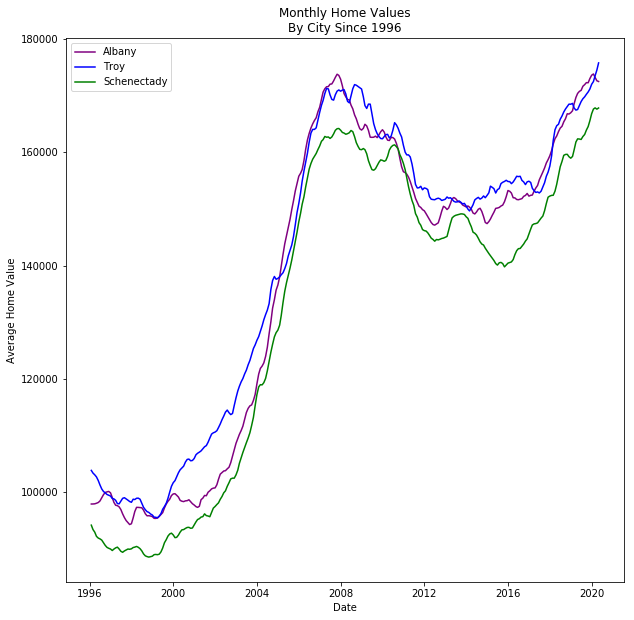

In [104]:
# Plot Some Data
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(ht_avg['Date'],
        ht_avg['Alb_Avg'],
        color='purple', 
        label = 'Albany')

ax.plot(ht_avg['Date'],
        ht_avg['Troy_Avg'],
        color='blue' ,
        label = 'Troy')

ax.plot(ht_avg['Date'],
        ht_avg['Schen_Avg'],
        color='green' ,
        label = 'Schenectady')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Average Home Value",
       title="Monthly Home Values\nBy City Since 1996")

leg = ax.legend();

plt.show()

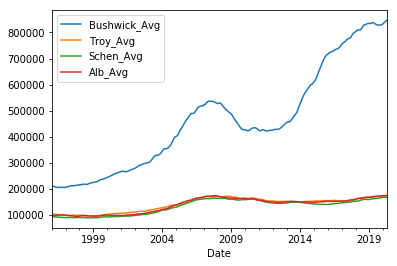

In [92]:
ht_avg.set_index('Date').plot();

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
0.6870479600179096
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
0.6819788974041504


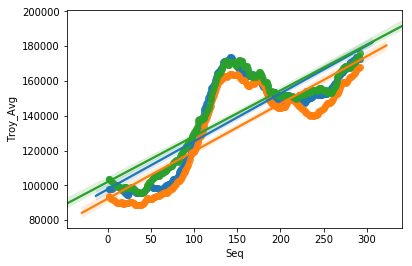

In [121]:
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = ht_avg[['Seq']]
Y = ht_avg['Alb_Avg']
lm = LinearRegression()
print(lm.fit(X,Y))
print(lm.score(X, Y))

X = ht_avg[['Seq']]
Y = ht_avg['Schen_Avg']
lm = LinearRegression()
print(lm.fit(X,Y))
print(lm.score(X, Y))

sns.regplot(x='Seq',y='Alb_Avg',data=ht_avg)
sns.regplot(x='Seq',y='Schen_Avg',data=ht_avg)
sns.regplot(x='Seq',y='Troy_Avg',data=ht_avg)

In [114]:
comp = ht_avg.loc[ht_avg['Date'] == '2020-04-30']
comp['Troy_Avg'] = comp['Troy_Avg'] * 3.15
comp['Schen_Avg'] = comp['Schen_Avg'] * 3.15
comp['Alb_Avg'] = comp['Alb_Avg'] * 3.15
comp

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,Date,Bushwick_Avg,Troy_Avg,Schen_Avg,Alb_Avg
292,2020-04-30,846830,553754,528666,543415


In [161]:
#Conducting a MannWhitney Test for statistically signfiicant differnece in values, we need to have the median of all values (all home values in each zip)
#thus in this section we obtain the median values and execute teh MannWhitneyU test to check if there is a difference between Schenectady and Albany home values

ht.columns.values[0] = "Date"
ht['Seq'] = ht.index
ht.head()

am = ht.groupby(['Seq'])[['A1', 'A2', 'A3', 'A4']].apply(np.median)
ht['Alb_Median'] = am

sm = ht.groupby(['Seq'])[['S1', 'S2']].apply(np.median)
ht['Schen_Median'] = sm

ht.tail()

,Date,BW1,BW2,T1,T2,A1,A2,A3,A4,S1,S2,Bushwick_Avg,Troy_Avg,Schen_Avg,Alb_Avg,Seq,Alb_Median,Schen_Median
288,12/31/2019,1158112,501716,188144,155897,216845,203571,137034,156061,192182,141470,829914,172020,166826,173621,288,179816.0,166826.0
289,1/31/2020,1163999,504299,188315,156683,217246,203696,137209,156309,192923,142352,834149,172499,167638,173840,289,180002.5,167637.5
290,2/29/2020,1169158,507026,188989,158051,216242,202697,136998,155902,192894,142802,838092,173520,167848,173234,290,179299.5,167848.0
291,3/31/2020,1173964,509759,189791,159260,215339,201520,136846,155413,192478,142774,841862,174526,167626,172638,291,178466.5,167626.0
292,4/30/2020,1181757,511904,191002,160588,214635,200478,137469,155378,192474,143187,846830,175795,167830,172513,292,177928.0,167830.5


In [171]:
from scipy.stats import mannwhitneyu

a = [214635,200478,137469,155378] #define the group of values of Albany Homes
s = [192474,143187] #Define the group of values of Schenectady Homes. 

#check significance between Albany and Schenectady to determine if these are independent in any way. 
#Hypothesis statement, are the values of Schenectady significantly different from Albany's home values?
#Null Hypothesis is that the values of each city are the same. 

stat, p = mannwhitneyu(a, s)
print('Statistics=%.8f, p=%.8f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

print('Given failure to reject the Null Hypothesis, it is assumed the values of homes in Albany vs. Schenectady Homes are the same.')

Statistics=3.00000000, p=0.40848066
Same distribution (fail to reject H0)
Given failure to reject the Null Hypothesis, it is assumed the values of homes in Albany vs. Schenectady Homes are the same.
